# AIoT Project

In [1]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%load_ext autoreload
%autoreload 2

Start time of execution

In [3]:
time_start = time()

## Load configuration

In [2]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path, encoding="utf-8") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
client = pymongo.MongoClient(config["client"])

In [4]:
db = client[config["db"]]
coll = db[config["col"]]

In [5]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['class_A', 'class_D', 'class_L', 'class_M', 'class_U']


## Load data

In [6]:
# [1] Load all documents from MongoDB (χωρίς το _id)
docs = list(
    coll.find(
        {},                   # no filter → όλα τα docs
        {"_id": 0, "label": 1, "data": 1}  # κρατάμε μόνο label & data
    )
)
print(f"Loaded {len(docs)} documents.")


Loaded 199 documents.


In [7]:
# [2] Φτιάχνουμε δύο λίστες:
#    X_raw: ένα pd.DataFrame ανά document
#    y_raw: το αντίστοιχο label

import pandas as pd

X_raw = [pd.DataFrame(d["data"]) for d in docs]
y_raw = [d["label"]            for d in docs]

# Έλεγχος
print("Example instance:")
print(" shape:", X_raw[0].shape)
print(" columns:", list(X_raw[0].columns))
print(" label:",   y_raw[0])


Example instance:
 shape: (5418, 3)
 columns: ['gyr_x', 'gyr_y', 'gyr_z']
 label: class_A


## Explore the nature of the data

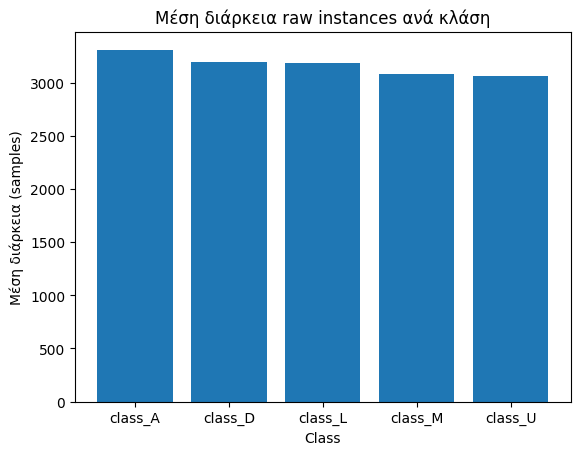

In [8]:
# Υπολογίζουμε μήκος (σε δείγματα) κάθε instance και το ομαδοποιούμε κατά label
durations = {}
for df, lbl in zip(X_raw, y_raw):
    n = len(df)  # όλα τα κανάλια έχουν ίδιο μήκος
    durations.setdefault(lbl, []).append(n)

# Υπολογίζουμε μέση τιμή ανά κλάση
avg_dur = {lbl: sum(vals)/len(vals) for lbl, vals in durations.items()}

# Σχεδιάζουμε bar‐plot
plt.figure()
plt.bar(avg_dur.keys(), avg_dur.values())
plt.xlabel("Class")
plt.ylabel("Μέση διάρκεια (samples)")
plt.title("Μέση διάρκεια raw instances ανά κλάση")
plt.show()


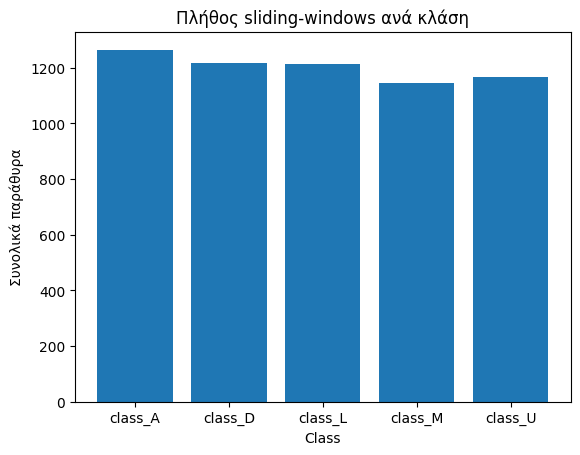

In [9]:
# Bar‐plot συνολικού πλήθους sliding‐windows ανά κλάση
window_counts = {}
for df, lbl in zip(X_raw, y_raw):
    wins = sliding_window_pd(
        df,
        ws       = config["sliding_window"]["ws"],
        overlap  = config["sliding_window"]["overlap"],
        w_type   = config["sliding_window"]["w_type"],
        w_center = config["sliding_window"]["w_center"],
        print_stats=False
    )
    window_counts[lbl] = window_counts.get(lbl, 0) + len(wins)

plt.figure()
plt.bar(window_counts.keys(), window_counts.values())
plt.xlabel("Class")
plt.ylabel("Συνολικά παράθυρα")
plt.title("Πλήθος sliding-windows ανά κλάση")
plt.show()


## Apply filter

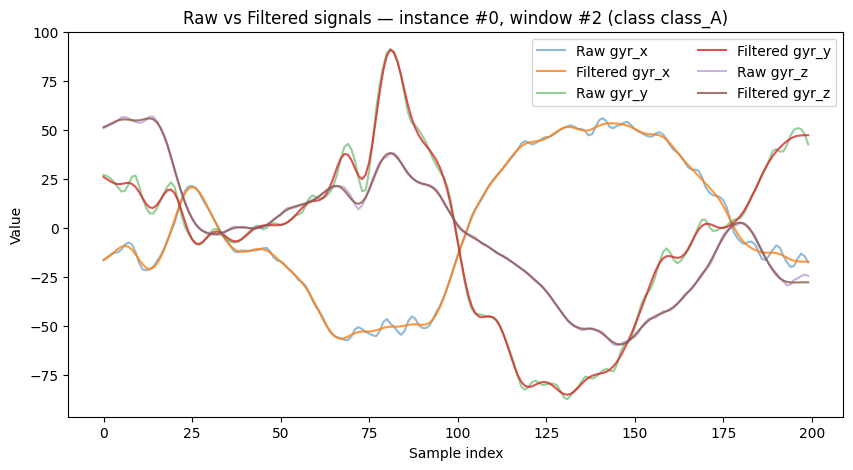

In [10]:
# — Apply low-pass filter to a selected sliding-window (all axes) —

# 1) Επιλογή instance και παράθυρου βάσει config
inst_idx = 0                             # εδώ διαλέγουμε το πρώτο raw instance
win_idx  = config.get("x_number", 0)     # index παραθύρου από το config

# 2) Δημιουργία των windows για το instance
windows = sliding_window_pd(
    X_raw[inst_idx],
    ws       = config["sliding_window"]["ws"],
    overlap  = config["sliding_window"]["overlap"],
    w_type   = config["sliding_window"]["w_type"],
    w_center = config["sliding_window"]["w_center"],
    print_stats=False
)

df_win = windows[win_idx]
label0 = y_raw[inst_idx]

# 3) Εφαρμογή low-pass φίλτρου σε όλους τους άξονες
df_filt = pd.DataFrame({
    col: apply_filter(
        df_win[col].to_numpy(),
        order      = config["filter"]["order"],
        wn         = config["filter"]["wn"],
        filter_type= config["filter"]["type"]
    )
    for col in df_win.columns
})

# 4) Σχεδίαση raw vs filtered (όλοι οι άξονες στο ίδιο plot)
plt.figure(figsize=(10,5))
for col in df_win.columns:
    plt.plot(df_win[col].to_numpy(),   alpha=0.5, label=f"Raw {col}")
    plt.plot(df_filt[col],             alpha=0.8, label=f"Filtered {col}")

plt.xlabel("Sample index")
plt.ylabel("Value")
plt.title(f"Raw vs Filtered signals — instance #{inst_idx}, window #{win_idx} (class {label0})")
plt.legend(loc="upper right", ncol=2)
plt.show()


## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [11]:
# 1) Συγκεντρώνουμε όλα τα windows και τα labels
windows_all = []
labels_all  = []

for df, lbl in zip(X_raw, y_raw):
    wins = sliding_window_pd(
        df,
        ws       = config["sliding_window"]["ws"],
        overlap  = config["sliding_window"]["overlap"],
        w_type   = config["sliding_window"]["w_type"],
        w_center = config["sliding_window"]["w_center"],
        print_stats=False
    )
    for w in wins:
        # w είναι DataFrame με στήλες ['gyr_x','gyr_y','gyr_z']
        windows_all.append(w.to_numpy())  
        labels_all.append(lbl)

# 2) Μετατροπή σε NumPy arrays
X = np.stack(windows_all)       # shape = (n_windows, ws, n_axes)
y = np.array(labels_all)        # shape = (n_windows,)

# 3) Έλεγχος σχημάτων
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6004, 200, 3)
y shape: (6004,)


## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [12]:
# Flatten 2D windows to 1D feature vectors
X_flat = X.reshape(X.shape[0], -1)   # now shape = (6004, 200*3 = 600)

# Έλεγχος σχήματος
print("X_flat shape:", X_flat.shape)


X_flat shape: (6004, 600)


## Train/Test split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# 20% των windows στο test set, shuffle με fixed seed για αναπαραγωγιμότητα
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y,
    test_size=0.20,
    shuffle=True,
    random_state=42,
    stratify=y      # για να κρατήσουμε την αναλογία των κλάσεων
)


In [15]:
print("Train set:", X_train.shape, y_train.shape)
print("Test  set:", X_test.shape,  y_test.shape)


Train set: (4803, 600) (4803,)
Test  set: (1201, 600) (1201,)


## Scaling

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [18]:
# Επιλέγουμε StandardScaler 
scaler = StandardScaler().fit(X_train)

# Μετασχηματίζουμε train και test
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("After scaling:")
print("Train:", X_train_scaled.shape)
print("Test: ", X_test_scaled.shape)


After scaling:
Train: (4803, 600)
Test:  (1201, 600)


## Transform to 2D again

In [19]:
from sklearn.decomposition import PCA

# 1) Φτιάχνουμε και «μαθαίνουμε» το PCA (2 components από το config)
pca = PCA(n_components=config["PCA"]["n_comp"]).fit(X_train_scaled)

# 2) Μετασχηματίζουμε train & test
X_train_2d = pca.transform(X_train_scaled)
X_test_2d  = pca.transform(X_test_scaled)

# 3) Έλεγχος σχημάτων
print("X_train_2d shape:", X_train_2d.shape)  # (4803, 2)
print("X_test_2d  shape:", X_test_2d.shape)   # (1201, 2)


X_train_2d shape: (4803, 2)
X_test_2d  shape: (1201, 2)


## Dimensionality Reduction with PCA using the 1D (flattened) data

In [20]:
# add transformers
from sklearn.decomposition import PCA

In [21]:
# 1) Φτιάχνουμε το PCA με n_components από το config
pca = PCA(n_components=config["PCA"]["n_comp"]).fit(X_train_scaled)

# 2) Εφαρμόζουμε τον μετασχηματισμό
X_train_pca = pca.transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3) Έλεγχος σχημάτων
print("X_train_pca shape:", X_train_pca.shape)  # → (4803, 2)
print("X_test_pca  shape:", X_test_pca.shape)   # → (1201, 2)

# 4) Προαιρετικά: τσεκάρουμε πόση διακύμανση «πιάνει» κάθε component
print("Explained variance ratio:", pca.explained_variance_ratio_)


X_train_pca shape: (4803, 2)
X_test_pca  shape: (1201, 2)
Explained variance ratio: [0.1194404  0.11336684]


### PCA with 2 Components

In [ ]:
# PCA με 2 components 
from sklearn.decomposition import PCA

pca2d = PCA(n_components=config["PCA"]["n_comp"])
pca2d.fit(X_train_scaled)   # μαθαίνουμε το PCA στο train set


,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [23]:
# PCA με 2 components 
from sklearn.decomposition import PCA

pca2d = PCA(n_components=config["PCA"]["n_comp"])
pca2d.fit(X_train_scaled)   # μαθαίνουμε το PCA στο train set


,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Principal component', ylabel='Explained variance (fraction) per component'>)

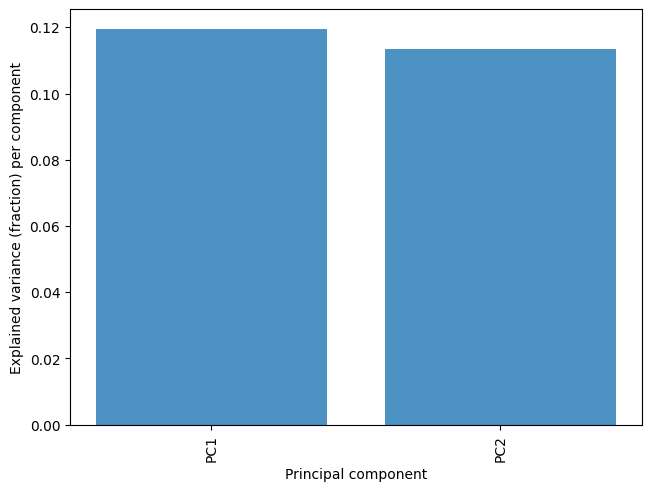

In [24]:
pca_explained_variance_bar(pca, alpha=0.8)

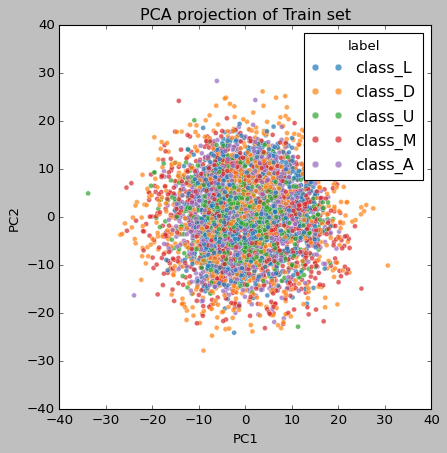

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="label",
    palette="tab10",    # ή όποιο palette θέλεις
    alpha=0.7
)
plt.title("PCA projection of Train set")
plt.show()


### PCA with 3 Components

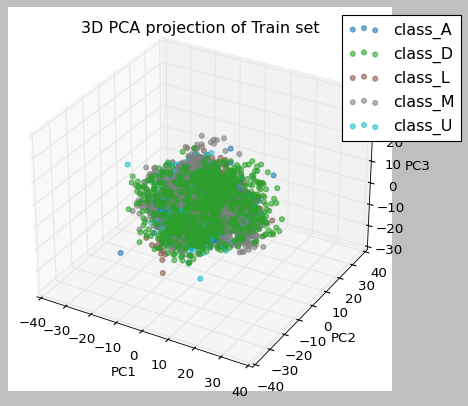

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# 1) Fit PCA με 3 components
pca3d = PCA(n_components=3).fit(X_train_scaled)
X_train_3d = pca3d.transform(X_train_scaled)

# 2) Χτίζουμε χρωματικό map για τις κλάσεις
unique_labels = np.unique(y_train)
# Παίρνουμε ένα colormap με τόσα χρώματα όσα οι κλάσεις
cmap = plt.get_cmap("tab10", len(unique_labels))
label_to_color = {lbl: cmap(i) for i, lbl in enumerate(unique_labels)}

# 3) Plot σε 3D με διαφορετικό χρώμα ανά κλάση
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
for lbl in unique_labels:
    mask = (y_train == lbl)
    ax.scatter(
        X_train_3d[mask, 0],
        X_train_3d[mask, 1],
        X_train_3d[mask, 2],
        color = label_to_color[lbl], 
        label = lbl,
        alpha = 0.6,
        s     = 20           # μικρότερα markers για καλύτερη διάκριση
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA projection of Train set")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()


### PCA with X% of the variance of the dataset, for training the statistical AI Models

In [30]:
from sklearn.decomposition import PCA

# 1) Ορίζουμε το ποσοστό διακύμανσης που θέλουμε να διατηρήσουμε
variance_threshold = 0.95

# 2) Μαθαίνουμε PCA με n_components=variance_threshold
pca_var = PCA(n_components=variance_threshold).fit(X_train_scaled)

# 3) Δείτε πόσες συνιστώσες τελικά έμειναν
n_comps = pca_var.n_components_
explained = pca_var.explained_variance_ratio_.sum()
print(f"PCA retains {explained:.2%} variance with {n_comps} components")

# 4) Μετατρέπουμε train & test sets
X_train_reduced = pca_var.transform(X_train_scaled)
X_test_reduced  = pca_var.transform(X_test_scaled)

print("Reduced shapes:", X_train_reduced.shape, X_test_reduced.shape)


PCA retains 95.14% variance with 52 components
Reduced shapes: (4803, 52) (1201, 52)


## Classifier - Statistical Learning

### Apply simple classifier

In [31]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Εδώ εκπαιδεύουμε SVC και RandomForest (χωρίς ακόμα evaluation)
svc = SVC(**config["classifier"]["SVC"]).fit(X_train_scaled, y_train)
rf  = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)
# Κάνουμε predict στο test set
y_pred_svc = svc.predict(X_test_scaled)
y_pred_rf  = rf.predict(X_test_scaled)

print(f"SVC predictions: {np.unique(y_pred_svc, return_counts=True)}")
print(f"RF  predictions: {np.unique(y_pred_rf, return_counts=True)}")


SVC predictions: (array(['class_A', 'class_D', 'class_L', 'class_M', 'class_U'], dtype='<U7'), array([306, 213, 223, 202, 257], dtype=int64))
RF  predictions: (array(['class_A', 'class_D', 'class_L', 'class_M', 'class_U'], dtype='<U7'), array([293, 217, 246, 221, 224], dtype=int64))


### Evaluate simple classifier

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [35]:
from sklearn.metrics import classification_report

=== SVC Classification Report ===
              precision    recall  f1-score   support

     class_A       0.78      0.94      0.85       253
     class_D       0.97      0.85      0.90       243
     class_L       0.92      0.85      0.88       243
     class_M       0.99      0.87      0.93       229
     class_U       0.83      0.92      0.87       233

    accuracy                           0.89      1201
   macro avg       0.90      0.89      0.89      1201
weighted avg       0.90      0.89      0.89      1201



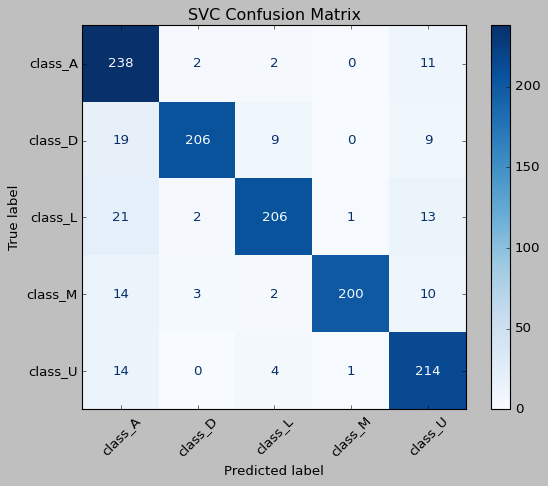


=== RF Classification Report ===
              precision    recall  f1-score   support

     class_A       0.80      0.93      0.86       253
     class_D       0.97      0.86      0.91       243
     class_L       0.87      0.88      0.88       243
     class_M       0.92      0.89      0.90       229
     class_U       0.94      0.90      0.92       233

    accuracy                           0.89      1201
   macro avg       0.90      0.89      0.89      1201
weighted avg       0.90      0.89      0.89      1201



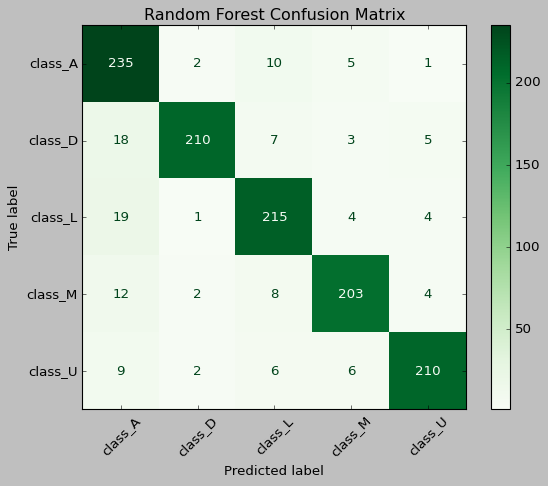

In [36]:
# 1) Classification report για SVC
print("=== SVC Classification Report ===")
print(classification_report(y_test, y_pred_svc))

# 2) Confusion matrix display για SVC
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("SVC Confusion Matrix")
plt.show()

# (Προαιρετικά) το ίδιο για RandomForest
print("\n=== RF Classification Report ===")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.show()


### Apply optimization with Grid Search and Cross-validation

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
# Στενότερο, αλλά εξακολουθεί να είναι exhaustive στο δεδομένο υποσύνολο
small_param_grid = [
    { "C":     [1, 10], "kernel": ["linear"] },
    { "C":     [1, 10], "gamma": [0.001, 0.0001], "kernel": ["rbf"] }
]

grid_fast = GridSearchCV(
    SVC(),
    param_grid  = small_param_grid,
    cv          = 3,     # Μειώνουμε τα folds από 5 σε 3
    verbose     = 1,
    n_jobs      = -1
)

grid_fast.fit(X_train_scaled, y_train)

print("Best parameters (fast grid):", grid_fast.best_params_)
print(f"Best CV score: {grid_fast.best_score_:.4f}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters (fast grid): {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV score: 0.8753


### Evaluate optimized classifier

=== Optimized SVC Classification Report ===
              precision    recall  f1-score   support

     class_A       0.79      0.92      0.85       253
     class_D       0.94      0.89      0.91       243
     class_L       0.93      0.84      0.88       243
     class_M       0.97      0.90      0.93       229
     class_U       0.85      0.90      0.87       233

    accuracy                           0.89      1201
   macro avg       0.90      0.89      0.89      1201
weighted avg       0.90      0.89      0.89      1201



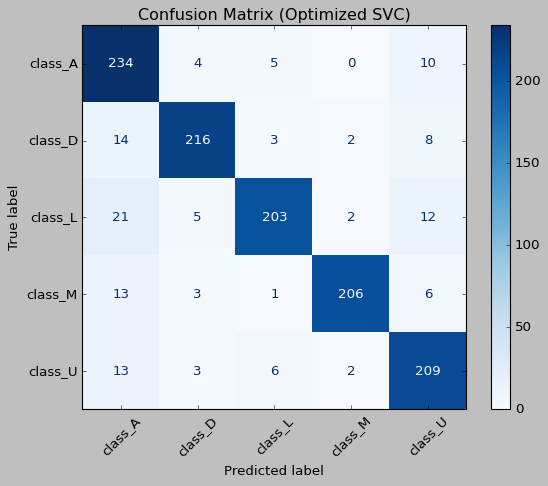

In [42]:
# Φορτώνουμε τον βελτιστοποιημένο estimator
best_svc = grid_fast.best_estimator_

# Πρόβλεψη στο test set
y_pred_opt = best_svc.predict(X_test_scaled)

# 1) Classification report
print("=== Optimized SVC Classification Report ===")
print(classification_report(y_test, y_pred_opt))

# 2) Confusion matrix display
cm_opt = confusion_matrix(y_test, y_pred_opt, labels=best_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=best_svc.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Optimized SVC)")
plt.show()

## Classifier - Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [ ]:
input_data_shape = X_train_2d[0].shape
print("Type of the input shape object:", type(input_data_shape))
X_train_2d[0].shape

In [ ]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

### Create the Neural Network (NN) Architecture and instantiate the model

In [ ]:
model = Sequential()

"""
BUILD YOUR MODEL ARCHITECTURE HERE
"""

model.add(Dense(n_outputs, activation="softmax"))

Plot the Architecture of ot the TensorFlow model

Plot the summary of the TensorFlow model

### Build the NN model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["ADD METRIC"])

In [ ]:
from utils import encode_labels

### Train the NN model

### Evaluate the model on the test data

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets